<h5 align="left"> Le 20 juin 2020</h5>
<img src="logo_PFA.png" width="970"align="left">
<h1 align="center">Projet de Fin d'Année</h1> 
<h1 align=center><font size = 5>Développement d’une heuristique pour la planification des tournées périodiques</font></h1>

## Table des matières

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Résolution avec la méthode exacte](#0)<br>
1.1 [Implémentation du modéle](#2)<br>
1.1.1 [Visualisation des données](#3)<br>
1.1.2 [Résultat exacte](#33)<br>
1.2 [Matrice des données](#4) <br>
1.3 [Calendrier des Patients](#6) <br>
2. [Heuristique proposée](#8) <br>
2.1 [Clustering: K-Means](#10) <br>
2.1.1 [Visualisation des données](#11)<br>
2.1.2 [La méthode Elbow](#12)<br>
2.1.3 [La méthode Silouhette](#13)<br>
2.1.4 [Résultat du Regroupement des Patients](#14)<br>
2.2 [Ajustement des clusters](#15) <br>
2.3 [Planification des tournées](#16) <br>
2.3.1 [coût des tournées](#17) <br>
2.3.2 [Calendrier des visites](#18) <br>
3. [Analyse des résultats](#19)
</div>
<hr>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Résolution avec la méthode exacte <a id="0"></a>
Nouira et al proposent un modèle mathématique linéaire à variables mixtes permettant de déterminer la fréquence optimale d’approvisionnement des consommables pour chaque patient. 
L’objectif est de satisfaire à la fois l’entreprise en réduisant la distance parcourue par période et le patient en réduisant le coût de stockage chez le patient.
<img src = "model.png" width = 500>

## Implémentation du modéle<a id="2"></a>
Nous utilisons le logiciel d'optimisation Gurobi 9.0.1 pour la résolution du problème

In [2]:
import numpy as np
from math import ceil
from gurobipy import *
import random
import itertools
rnd=np.random
rnd.seed(0)

In [3]:
def combinaison(P):
    q=[]
    for L in range(len(P)+1):
        for subset in itertools.combinations(P, L):
            if len(subset)>=2:
                q.append(tuple(subset))
    return (q)

In [7]:
n=8 #number of patients
k=3 #number of vehicules
C=1208
D=1206
P=[i for i in range(1,n+1)] #list of patients
N=[0]+P
Pc = {i:rnd.randint(100,1206) for i in P}  #patients capacity
loc_x = rnd.rand(len(N))*200 #patients loc
loc_y = rnd.rand(len(N))*150
A=[(i,j) for i in N for j in N if i!=j]
sk=[i for i in range(1,k+1)] #set of vehicules
T=[i for i in range(1,7)] #set of days represanting the period
c={(i,j):np.hypot(loc_x[i]-loc_x[j],loc_y[i]-loc_y[j]) for i,j in A} #cost of traveling from node i to j
S = [(1,5), (1,3,5), (1,2,3,4,5,6)] #Set of proposed service schedules
sf=dict(zip(S,[2,3,6])) #Service frequency for schedule s
hp=0.3 #holding cost per unit
s_cp=dict(zip(S,[0.45,0.3,0.18])) #Storage cost according to schedule s
st_c=dict(zip(S,[0.3,0.2,0.1])) #stopping cost for each schedule
Q=combinaison(P)
a_sd={(s,d):1 if (d in s) else 0 for s in S for d in T } #equal to one if day d is in the schedule s and 0 otherwise 

<h3> Visualisation des données </h3><a id="3"></a>

<IPython.core.display.Javascript object>


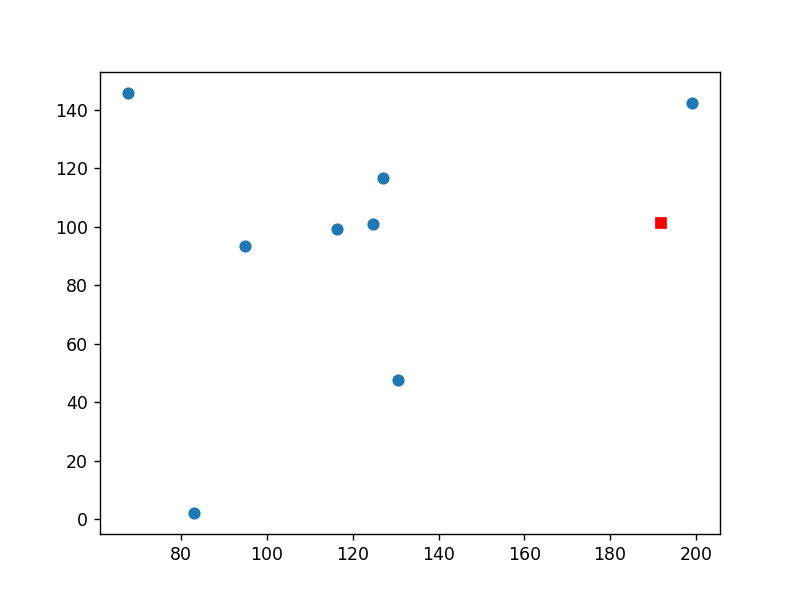

In [8]:
%matplotlib notebook
plt.scatter(loc_x[1:],loc_y[1:])
plt.plot(loc_x[0],loc_y[0],c='r',marker='s')

In [9]:
mdl = Model("PVRP")

Using license file C:\Users\dell\gurobi.lic
Academic license - for non-commercial use only


<h3>Variables de decision</h3>

In [10]:
X = mdl.addVars([(i,j,k,d) for i,j in A for k in sk for d in T], vtype=GRB.BINARY, name="X")
Y = mdl.addVars([(p,k,s) for p in P for k in sk for s in S], vtype=GRB.BINARY, name="Y")
W = mdl.addVars([(p,d,k) for p in P for d in T for k in sk], vtype=GRB.INTEGER, lb=0, name="W")

<h3>Fonction Objectif</h3>

In [11]:
mdl.setObjective(quicksum(c[i,j] * X[i,j,k,d] for i,j in A for d in T for k in sk) + 
                  quicksum(s_cp[s]+(st_c[s]*sf[s]*Y[p,k,s]) for s in S for p in P for k in sk), GRB.MINIMIZE)

<h3>Les contraintes</h3>

In [12]:
mdl.addConstrs(quicksum(Y[p,k,s] for k in sk for s in S) == 1 for p in P)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>}

In [13]:
mdl.addConstrs(quicksum(W[p,d,k] for p in P) <= C for d in T for k in sk)

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 2): <gurobi.Constr *Awaiting Model Update*>,
 (4, 3): <gurobi.Constr *Awaiting Model Update*>,
 (5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 2): <gurobi.Constr *Awaiting Model Update*>,
 (5, 3): <gurobi.Constr *Awaiting Model Update*>,
 (6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (6, 2): <gurobi.Constr *Awaiting Model Update*>,
 (6, 3): <gurobi.Constr *Awaiting Model Update*>}

In [14]:
mdl.addConstrs(W[p,d,k] <= Pc[p] for p in P for d in T for k in sk)

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Upd

In [15]:
mdl.addConstrs((quicksum(X[p,j,k,d] for j in N if p!=j)) == (quicksum(a_sd[s,d]*Y[p,k,s] for s in S)) for p in P for d in T for k in sk)

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Upd

In [16]:
mdl.addConstrs(quicksum(X[i,j,k,d] for j in N if i!=j) == quicksum(X[j,i,k,d] for j in N if i!=j) for i in N for k in sk for d in T)

{(0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 1): <gurobi.Constr *Awaiting Model Upd

In [17]:
mdl.addConstrs(quicksum(X[0,j,k,d] for j in N if j!=0) == 1 for k in sk for d in T)

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (3, 4): <gurobi.Constr *Awaiting Model Update*>,
 (3, 5): <gurobi.Constr *Awaiting Model Update*>,
 (3, 6): <gurobi.Constr *Awaiting Model Update*>}

In [18]:
mdl.addConstrs(quicksum(X[i,j,k,d] for i in t for j in t if i!=j) <= (len(t)-1) for t in Q for k in sk for d in T)

{((1, 2), 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 2, 2): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 2, 3): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 2, 4): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 2, 5): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 2, 6): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 3, 2): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 3, 3): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 3, 4): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 3, 5): <gurobi.Constr *Awaiting Model Update*>,
 ((1, 2), 3, 6

<h3>Résolution Exacte</h3><a id="33"></a>

In [19]:
mdl.optimize()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 4940 rows, 1512 columns and 69024 nonzeros
Model fingerprint: 0x99f9e289
Variable types: 0 continuous, 1512 integer (1368 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 162 rows and 144 columns
Presolve time: 0.12s
Presolved: 4778 rows, 1368 columns, 68592 nonzeros
Variable types: 0 continuous, 1368 integer (1368 binary)
Found heuristic solution: objective 5628.7769300

Root relaxation: objective 2.667623e+03, 242 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2667.62305    0   24 5628.77693 2667.62305  52.6%     -    0s
H    0     0                    2906.7310813 2667.62305  8.23%     -    0s
H    0     0                    2848.938

<h3>Valeur de la fonction objectif</h3>

In [20]:
mdl.ObjVal

2748.5298175389903

# Matrice des distances<a id="4"></a>

In [21]:
dis_data = np.zeros((len(N),len(N)))
for i in range(len(N)):
    for j in range(len(N)):
        if i!=j:
            dis_data[i,j]=c[i,j]

In [22]:
col = ['Depot']
for i in range(1,len(dis_data)):
    col.append('patient {0}'.format(i))

In [23]:
df_dist =pd.DataFrame(dis_data,
                     index = col,
                     columns = col)
df_dist.replace(to_replace=0, value='______', inplace=True)

In [24]:
df_dist

Depot patient 1 patient 2 patient 3 patient 4 patient 5  \
Depot       ______   81.3989   66.6158    41.859   75.4421   147.305   
patient 1  81.3989    ______   69.2624   117.004   53.7067   65.9401   
patient 2  66.6158   69.2624    ______   76.4892    20.373   122.914   
patient 3   41.859   117.004   76.4892    ______   93.2281    182.24   
patient 4  75.4421   53.7067    20.373   93.2281    ______   102.945   
patient 5  147.305   65.9401   122.914    182.24   102.945    ______   
patient 6  97.1628   58.0568   39.6571   115.078   22.2418   92.1842   
patient 7   67.088   53.7884   15.8718   85.0997   8.49765   107.486   
patient 8  131.947   116.658   66.1279   131.501   67.3239   144.565   

          patient 6 patient 7 patient 8  
Depot       97.1628    67.088   131.947  
patient 1   58.0568   53.7884   116.658  
patient 2   39.6571   15.8718   66.1279  
patient 3   115.078   85.0997   131.501  
patient 4   22.2418   8.49765   67.3239  
patient 5   92.1842   107.486   144.565  
patient 6    ______    30.723   59.0715  
patient 7    30.723    ______   72.5423  
patient 8   59.0715   72.5423    ______

# Calendrier des Patients<a id="6"></a>

In [25]:
qqq = [i for i in list(Y.keys()) if Y[i].x >= 1.0]
data = [(i[1],len(i[2])) for i in qqq]
data2 = np.zeros((len(P),6))
for k in qqq:
    if(len(k[2])==2):
        data2[k[0]-1,::4]=1
    elif(len(k[2])==3):
        data2[k[0]-1,::2]=1
    else:
        data2[k[0]-1,::]=1

In [26]:
day =['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi']
summary = pd.DataFrame(index = col[1:], columns = ['N° vehicule', 'Frequence_visite']+day)
summary[['N° vehicule', 'Frequence_visite']] = data
summary[day] = data2

In [27]:
summary

N° vehicule Frequence_visite Lundi Mardi Mercredi Jeudi Vendredi  \
patient 1           3                2     1     0        0     0        1   
patient 2           2                6     1     1        1     1        1   
patient 3           1                6     1     1        1     1        1   
patient 4           3                2     1     0        0     0        1   
patient 5           3                2     1     0        0     0        1   
patient 6           3                2     1     0        0     0        1   
patient 7           3                6     1     1        1     1        1   
patient 8           3                2     1     0        0     0        1   

          Samedi  
patient 1      0  
patient 2      1  
patient 3      1  
patient 4      0  
patient 5      0  
patient 6      0  
patient 7      1  
patient 8      0

In [28]:
%matplotlib inline
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

==== RESULTS ====
Min Cost: 2748.5298175389903


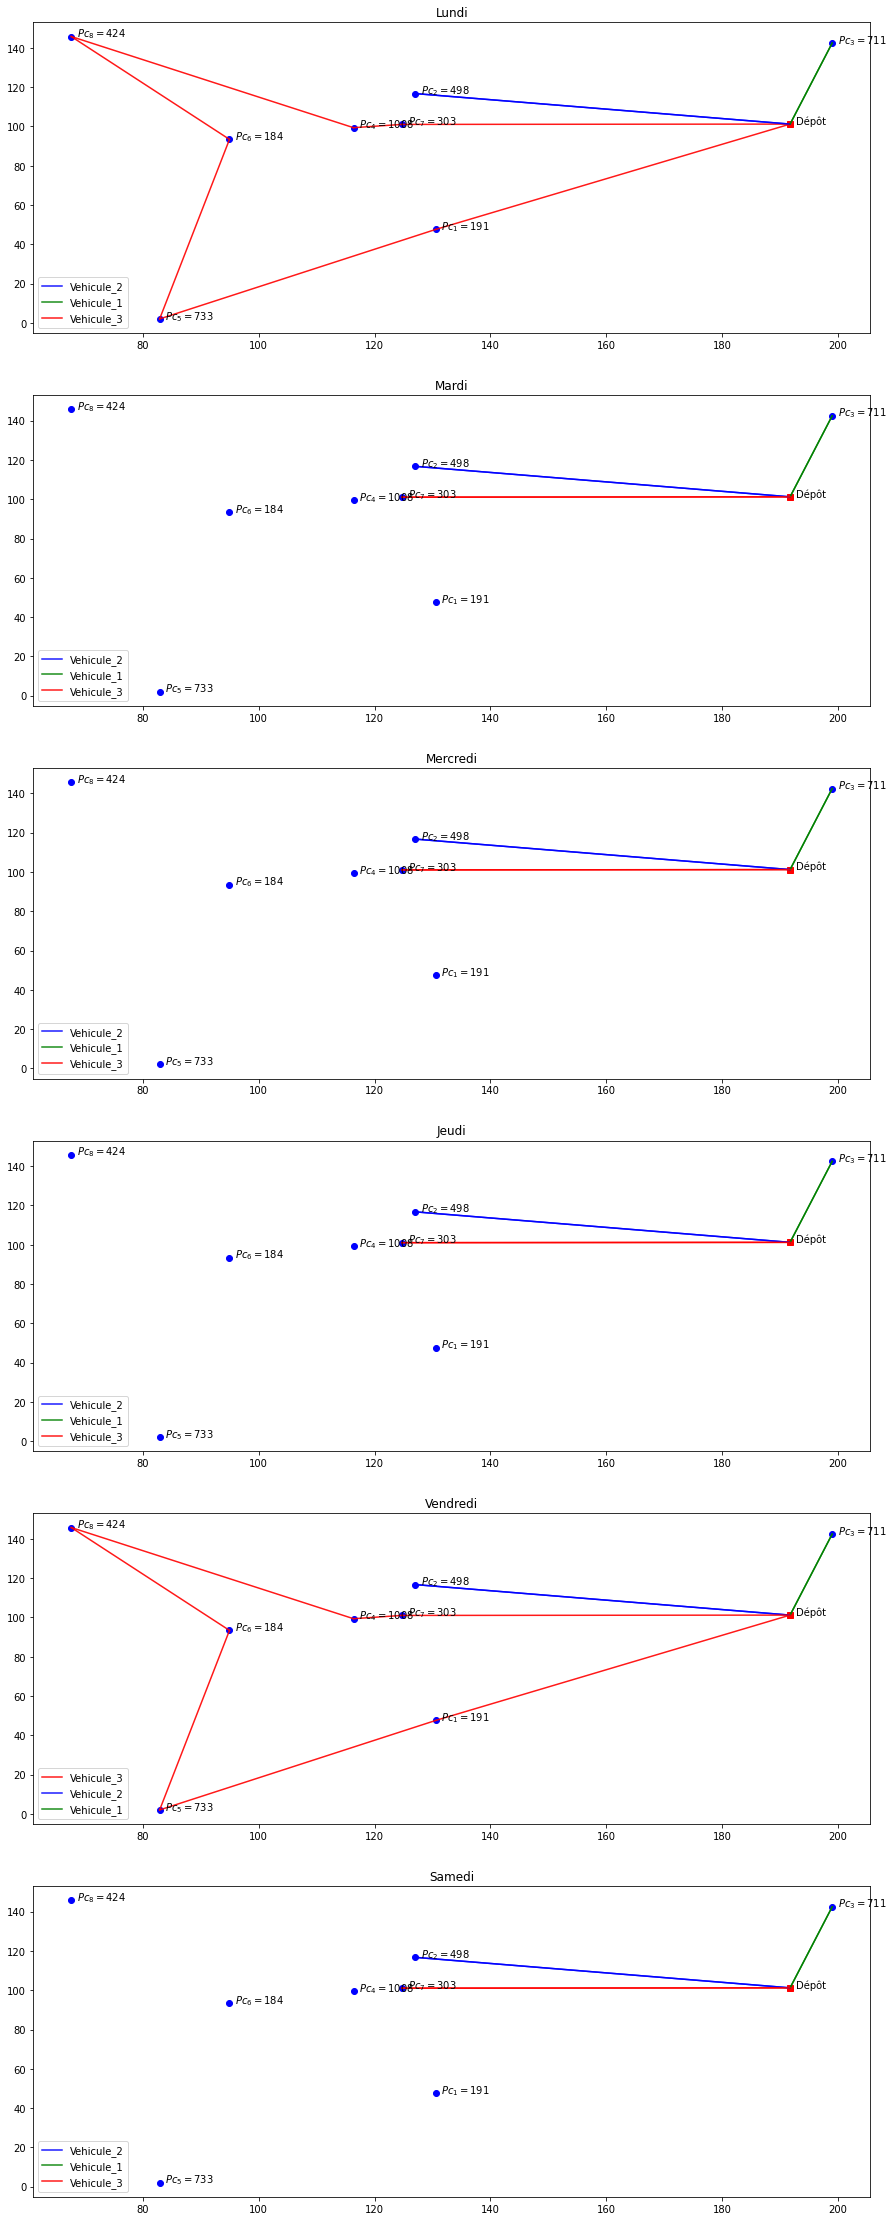

In [29]:
if ((mdl.status == 2)or(mdl.status == 9)):
    print('==== RESULTS ====')
    print('Min Cost: {}'.format(mdl.ObjVal))
    fig = plt.figure(figsize=(15,40))
    day =['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi']
    qqq = [i for i in list(X.values()) if i.x >= 1]
    hh =[]
    for q in qqq:
        for i in list(X.keys()):
            if (str(X[i])==str(q)):
                hh.append(i)
                break
    for i in range(1, 7):
        ax = fig.add_subplot(6, 1, i)
        ax.title.set_text(day[i-1])
        s = i
        ax.scatter(loc_x[1:],loc_y[1:],c='b')
        for i in P:
            ax.annotate('$Pc_{%d}=%d$'%(i,Pc[i]),(loc_x[i]+1,loc_y[i]),c='black')
        ax.plot(loc_x[0],loc_y[0],c='r',marker='s')
        ax.annotate('Dépôt',(loc_x[0]+1,loc_y[0]))

        arc=[b for b in hh if b[3]==s]

        for i,j,k,d in arc:
            if k==1:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='g',alpha=0.9, label='Vehicule_1')
            elif k==2:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='b',alpha=0.9, label='Vehicule_2')
            elif k==3:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='r',alpha=0.9, label='Vehicule_3')
            elif k==4:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='m',alpha=0.9, label='Vehicule_4')
            elif k==5:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='black',alpha=0.9, label='Vehicule_5')
            elif k==6:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='deepskyblue',alpha=0.9, label='Vehicule_6')
            elif k==7:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='teal',alpha=0.9, label='Vehicule_7')
            elif k==8:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='skyblue',alpha=0.9, label='Vehicule_8')
            elif k==9:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='yellow',alpha=0.9, label='Vehicule_9')
            else:
                ax.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='deeppink',alpha=0.9, label='Vehicule_10')
        legend_without_duplicate_labels(ax)

else:
    print('Infeasible model')

# Heuristique proposée<a id="8"></a>
Le modèle implémenté permet de résoudre des problèmes de petite taille. Ainsi, des heuristiques sont nécessaires pour résoudre des problèmes de grande taille.
Dans le cadre de notre projet de fin d’année, nous allons proposer une heuristique permettant de traiter le problème d’approvisionnent des patients en consommables.
Notre approche comporte deux phases:
<ul>
    <li> Clustering</li>
    <li> Planification des tournées</li>
</ul>
Dans un premier temps, nous regroupons les patients en clusters. Chaque cluster est affecté à un véhicule. 
Les patients dans un même cluster devraient donc être proches géographiquement. 
La somme des demandes des patients du même cluster ne doit pas dépasser la capacité du véhicule. 
Ensuite, une fois les clusters sont formés, nous déterminons la tournée de chaque véhicule. 

## Clustering: K-Means <a id="10"></a>
L’algorithme K-Means nécessite d’introduire comme paramètre un nombre de clusters. L’obtention d’un nombre optimal de clusters K pour aboutir au meilleur résultat n'est pas évidente.
Dans cette partie, nous présentons des moyens pour déterminer K mathématiquement
<ul>
    <li> La méthode Elbow </li>
    <li> La méthode silouhette </li>
</ul>

In [3]:
N=200 #nmbre de patients
P={i:(rnd.uniform(30, 200),rnd.uniform(40, 250),random.randint(100,600)) for i in range(1,N+1)} #{patient:(x,y,Capacité)}
C=dict(zip(P.keys(), [c[2] for c in P.values()]))
X=[x[0] for x in P.values()] #liste des abscisses de tout les patients
Y=[y[1] for y in P.values()] #liste des ord 
CC=[c[2] for c in P.values()]
d=1206/6 #demande journalière d'un patient
Q=2000 #capacite d'une vehicule
T=[i for i in range(1,7)] #L’horizon de planification
depot_x = rnd.uniform(30, 200)
depot_y = rnd.uniform(30, 200)

<h3> Visualisation des données </h3><a id="11"></a>

<IPython.core.display.Javascript object>


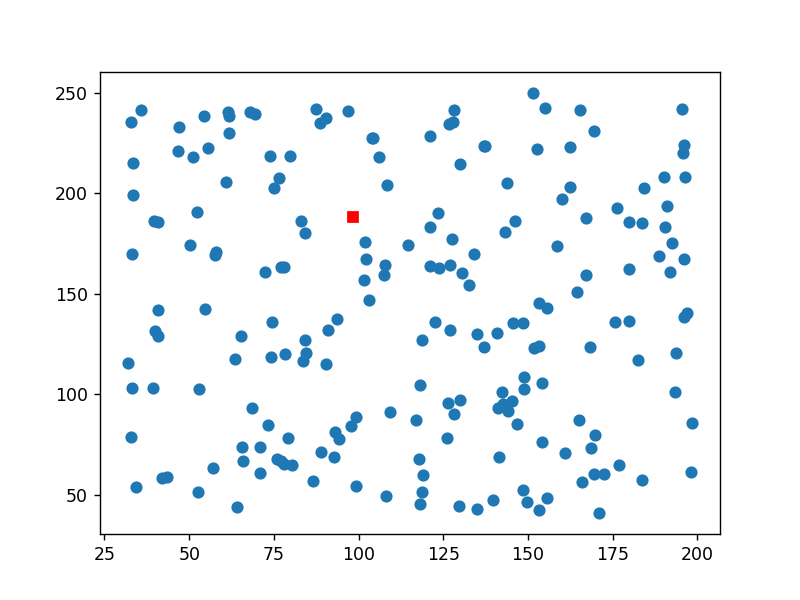

In [4]:
%matplotlib notebook
plt.scatter(X,Y)
plt.plot(depot_x,depot_y,c='r',marker='s')

In [5]:
from sklearn.cluster import KMeans

dt = pd.DataFrame(list(zip(X,Y)))
dt['capacite'] = CC
dt.columns=['x','y', 'capacite']
max_x = dt['x'].max()
max_y = dt['y'].max()
max_cap = dt['capacite'].max()
dt['x']=(dt['x']/max_x)
dt['y']=(dt['y']/max_y)
dt['capacite']=dt['capacite']/max_cap

<h3> La méthode Elbow </h3><a id="12"></a>

<Figure size 720x720 with 0 Axes>

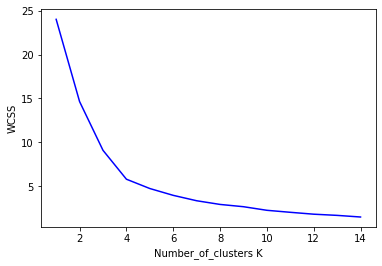

In [6]:
%matplotlib inline
wcss = []
plt.figure(figsize=(10,10))
K = range(1, 15)
for i in K:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(dt[['x', 'y']])
    wcss.append(kmeans.inertia_)
plt.figure("figure2")
plt.plot(K, wcss,'b')
plt.xlabel('Number_of_clusters K')
plt.ylabel('WCSS')
plt.show()

<h3> La méthode Silhouette </h3><a id="13"></a>

<Figure size 720x720 with 0 Axes>

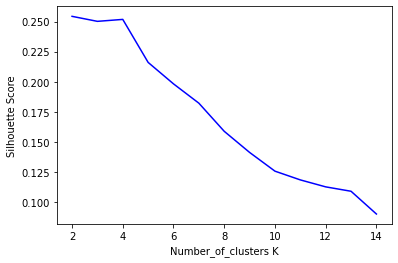

In [7]:
from sklearn.metrics import silhouette_score
sil = []
plt.figure(figsize=(10,10))
kmax = 14
K = range(2, kmax+1)
for k in K:
    kmeans = KMeans(n_clusters = k).fit(dt[['x', 'y']])
    labels = kmeans.labels_
    sil.append(silhouette_score(dt, labels, metric = 'euclidean'))
plt.figure("figure3")
plt.plot(K, sil,'b')
plt.xlabel('Number_of_clusters K')
plt.ylabel('Silhouette Score')
plt.show()

La méthode Elbow et la méthode de la silhouette ne sont pas des alternatives pour trouver le K optimal. Ce sont plutôt des outils à utiliser ensemble pour une décision plus confiante.

In [8]:
import time
from math import *
import copy

<h3>Initialisation de K </h3>

In [9]:
K=3 # Nb des clusters initialment

In [10]:
t = time.time()
def Affecter(i,PA):
    if i in PA:
        return(0)
    else:
        return(1)
    
def somme_capacite():
    return(sum(c for c in C.values()))

def get_key(val): 
    for key, value in eucl_dist.items(): 
        if val == value: 
            return key

def distance_patient_centroide(i,s): #i: num patient -- s: num centroide
    return sqrt(((S[s][0]-P[i][0])**2)+((S[s][1]-P[i][1])**2))

def somme_assigner(i):
    variable=0
    for k in range(1,K):
        variable+=assigner[(i,k)]
    return variable

def patients_data(i):
    dict_patient_data={}
    for s in S.keys(): #parcours sur les centroides
        dict_patient_data[(i,s)]=distance_patient_centroide(i,s) #[(patient, centroide): distance entre les deux)]
    return(dict_patient_data)

def get_centroid(val,dict_data): 
    for value in dict_data.values(): 
        for key in dict_data.keys():
            if dict_data[key] == val:
                return key[1]

def to_the_cluster(i):
    dict_data=patients_data(i)
    min_dis=min(dict_data.values())
    centroide=get_centroid(min_dis,dict_data)
    Cap[centroide]=Cap[centroide]+C[i]
    assigner[(i,centroide)]=1
    clusters_utilise[centroide].append(i)
    del(P_non_affecte[i])

In [11]:
P_non_affecte = copy.deepcopy(P)
C_non_affecte=dict(zip(P_non_affecte.keys(), [c[2] for c in P_non_affecte.values()]))
x_center=d*sum(x for x in list(P[i][0] for i in P.keys()))/sum(d for i in range(1,N+1))
y_center=d*sum(y for y in list(P[i][1] for i in P.keys()))/sum(d for i in range(1,N+1))
centre_de_gravite=(x_center,y_center) #coord centre de gravité ee tous les patients

k=0
S={}
clusters_utilise={}
Cap={k:0 for k in range(1,K+1)} #capacité des clusters iitialisé à 0
assigner={(i,k):0 for i in range(1,N+1) for k in range(1,K+1)} #Initialiser assigner (i, k)=0
eucl_dist={}
PA=[i for i in range(1,N+1)]
while (k < K+1):
    for i in P_non_affecte.keys():
        if Affecter(i,PA)==0:
            eucl_dist[(i,k)]=sqrt(((x_center-P_non_affecte[i][0])**2)+((y_center-P_non_affecte[i][1])**2))
           
    max_distance=max(eucl_dist.values())
    i_star_cluster_tuple=get_key(max_distance)
    i_star=i_star_cluster_tuple[0]
    S[k]=[P_non_affecte[i_star][0],P_non_affecte[i_star][1]]
    centre_de_gravite=S[k]
    Cap[k]=C_non_affecte[i_star]
    del(P_non_affecte[i_star])
    PA.remove(i_star)
    assigner[(i_star,k)]=1
    clusters_utilise[k]=[i_star]
    eucl_dist={}
    k+=1

In [12]:
max_iteration=300
nbre_iteration=0
test={}   
while test!=S and nbre_iteration<max_iteration:
    nbre_iteration+=1
    test = copy.deepcopy(S)
    P_non_affecte = copy.deepcopy(P)
    clusters_utilise={k:[] for k in S.keys()}
    Cap={k:0 for k in S.keys()}
    assigner={(i,k):0 for i in range(1,N+1) for k in range(1,K+1)} #Initialiser assigner (i, k)=0
    
    patients_non_affecte = copy.deepcopy(P)
    for i in patients_non_affecte.keys():
        to_the_cluster(i)
    
    for clus in clusters_utilise.keys():
        S[clus][0]=sum(P[i][0] for i in clusters_utilise[clus])/len(clusters_utilise[clus])
        S[clus][1]=sum(P[i][1] for i in clusters_utilise[clus])/len(clusters_utilise[clus])

In [13]:
mm={}
for j in clusters_utilise.keys():
    for k in clusters_utilise[j]:
            mm[k]=j
dict_patient_cluster=mm

dt = pd.DataFrame()
dt['x']=[P[i][0] for i in sorted(dict_patient_cluster.keys())]
dt['y']=[P[i][1] for i in sorted(dict_patient_cluster.keys())]
dt['capacite']=[P[i][2] for i in sorted(dict_patient_cluster.keys())]
dt['clusters']=[dict_patient_cluster[key] for key in sorted(dict_patient_cluster.keys())]
dt['clusters']=dt['clusters'].astype(int)

In [14]:
max_x = dt['x'].max()
max_y = dt['y'].max()
max_cap = dt['capacite'].max()
dt['x']=(dt['x']/max_x)
dt['y']=(dt['y']/max_y)
dt['capacite']=dt['capacite']/max_cap

In [15]:
centers = np.zeros((len(S),2))
for k in range(len(S)):
    centers[k,:] = np.array(S[k])

<h3> Résultat du Regroupement des Patients </h3><a id="14"></a>

In [16]:
import plotly.express as px

In [17]:
def without_norm(data,mx,my,mc):    # return dataframe EI
    data2=data.copy()
    data2["capacite"] = data["capacite"] * mc
    data2["x"] = data["x"] * mx
    data2["y"] = data["y"] * my
    data2["capacite"]=data2["capacite"].astype(int)
    data2=data2.round({'x':6,'y':6})
    return data2

def grouper(data_f):        # return dataframe groupby clusters and sum cap
    df_solution = data_f.groupby(['clusters'],as_index=True).agg({'capacite':sum,'clusters':'count'})
    df_solution["nb_Vh"] = (df_solution['capacite']/Q).apply(np.ceil)
    df_solution.columns=['capacite','patients','nb_Vh']
    return df_solution

In [18]:
dt

x         y  capacite  clusters
0    0.621596  0.761497  0.892797         1
1    0.667833  0.618301  0.216080         1
2    0.514330  0.703232  0.654941         2
3    0.526271  0.909971  0.711893         0
4    0.977137  0.482558  0.350084         1
5    0.829780  0.604858  0.333333         1
6    0.638078  0.938410  0.740369         0
7    0.212123  0.233415  0.931323         3
8    0.168570  0.860234  0.356784         0
9    0.818152  0.891674  0.867672         1
10   0.989955  0.832099  0.891122         1
11   0.546747  0.816435  0.497487         0
12   0.252608  0.698210  0.236181         2
13   0.274101  0.954446  0.571189         0
14   0.598486  0.508809  0.512563         2
15   0.377976  0.811142  0.795645         0
16   0.542180  0.638103  0.894472         2
17   0.167346  0.679472  0.182580         2
18   0.675831  0.678882  0.180905         1
19   0.960070  0.733439  1.000000         1
20   0.459354  0.527618  0.740369         2
21   0.749138  0.210794  0.502513         3
22   0.722686  0.724037  0.579564         1
23   0.331548  0.268558  0.768844         3
24   0.421576  0.465968  0.755444         2
25   0.639922  0.528938  0.298157         2
26   0.998316  0.245956  0.733668         3
27   0.330257  0.295786  0.499162         3
28   0.710981  0.373126  0.874372         3
29   0.550888  0.365672  0.956449         3
..        ...       ...       ...       ...
170  0.469077  0.325841  0.415410         3
171  0.545356  0.197666  0.371859         3
172  0.836697  0.224861  0.480737         3
173  0.595903  0.418125  0.882747         3
174  0.646218  0.966860  0.643216         0
175  0.704520  0.189888  0.288107         3
176  0.520113  0.588985  0.618090         2
177  0.610766  0.733080  0.623116         1
178  0.389152  0.268503  0.847571         3
179  0.487780  0.964315  0.338358         0
180  0.311620  0.920238  0.247906         0
181  0.617304  0.544333  0.973199         2
182  0.907185  0.545756  0.373534         1
183  0.771881  0.495661  0.390285         1
184  0.926042  0.740338  0.788945         1
185  0.750845  0.435707  0.681742         3
186  0.799830  0.694964  0.537688         1
187  0.356948  0.295138  0.519263         3
188  0.833780  0.966636  0.249581         1
189  0.543884  0.657063  0.453936         2
190  0.886343  0.544595  0.345059         1
191  0.967034  0.644255  0.989950         1
192  0.854671  0.924324  0.383585         1
193  0.850177  0.294193  0.755444         3
194  0.690232  0.495164  0.921273         3
195  0.204989  0.516688  0.993300         2
196  0.372944  0.874039  0.958124         0
197  0.179785  0.966482  0.701843         0
198  0.455807  0.460079  0.283082         2
199  0.165236  0.315901  0.324958         2

[200 rows x 4 columns]

In [19]:
dt_copy = dt.copy()
dt_copy['clusters'] = dt_copy['clusters'].astype(str)
fig = px.scatter(dt_copy, x='x', y='y', color='clusters')
fig

<h3> Verification de capacité des clusters </h3>

In [20]:
ver_df=without_norm(dt_copy,max_x,max_y,max_cap)
grouper(ver_df)

capacite  patients  nb_Vh
clusters                           
0            12632        36    7.0
1            19628        59   10.0
2            13093        37    7.0
3            23635        68   12.0

Il est clair qu'il y a des clusters qui dépassent leur capacité.
On va ajuster les clusters créés pour respecter la contrainte « capacitée » à travers un algorithme d’ajustement. 

## Ajustement des clusters <a id="15"></a>
 L’objectif est de former des clusters qui respectent la capacité du véhicule. En fait, chaque véhicule sera affecté à un cluster. Les clusters créés à travers notre algorithme initial n’ont pas tenu compte la capacité du véhicule. De ce fait, on est appelé à calculer la capacité de chaque cluster et l’ajuster si nécessaire

In [21]:
from scipy.spatial import distance

def centr_nor(centr,mx,my,mc):
    cc=centr.copy()
    cc[:,0]=centr[:,0] * mx
    cc[:,1]=centr[:,1] * my
    return cc
def list_good_cluster(df_solution):  # return list of good cluster ( sum(cap) <= C)
    list_clust_satisf=list(df_solution[df_solution['capacite']<=Q].index)
    return list_clust_satisf

def list_bad_cluster(df_solution):    # return list of bad cluster ( sum(cap) > C)
    list_clus_prob=list(df_solution[df_solution['capacite']>Q].index)     #list des clusters qui ont un probleme
    return list_clus_prob
def clus_possibilite(df_solution,centers):   #return dict of good cluster: ((centr_x, centr_y), cap_rest)
    possibilte = {}
    list_clust_satisf = list_good_cluster(df_solution)
    for i in list_clust_satisf:
        possibilte[i]=(centers[int(i)], int(Q-df_solution['capacite'][i]))   #centroides , cap rest
    return possibilte

def df_clus_prob(df,list_clus_prob):
    df_prob = df[df['clusters'].isin(list_clus_prob)]
    return df_prob

def patients_convoque(dt_prob,list_clus):   #list_clus = list of bad cluster
    pat_conv = {}
    for k in list_clus:
        all_index = list(dt_prob[dt_prob['clusters']==k].index)
        pat_conv[k] = [[(np.array((dt_prob[dt_prob['clusters']==k].loc[indice].x, dt_prob[dt_prob['clusters']==k].loc[indice].y))), dt_prob[dt_prob['clusters']==k].loc[indice].capacite]for indice in all_index]
    return pat_conv

def comparing_distance(L,centr):#L= {'0':(array([104.90963191,  40.95749613]), 272.0)} , centr=array()
    val=[]
    for i in range(len(L)):
        val.append(distance.euclidean(centr,L[i][0]))
    indice=val.index(min(val))
    return(L[indice],val[indice])  #(cluster, dist_patient le plus proche)

def patients_choisie(convocation,possibilte):           #{cluster n° i: coor du patients a ajoute au cluster i}
    dic_patients_choisie = {}
    intermid = {}
    for j in possibilte.keys():
        l_dis=[]
        for i in convocation.keys():
            valeur=[]
            for k in range(len(convocation[i])):
                if convocation[i][k][1]<=possibilte[j][1]:
                    valeur.append(convocation[i][k])
            intermid[i]=valeur    
            if len(intermid[i])!=0:
                desc,dist=comparing_distance(intermid[i],possibilte[j][0])
                l_dis.append((desc,dist))
        if len(l_dis)!=0:
            d,dic=min(l_dis, key = lambda t: t[1])    
            dic_patients_choisie[j]=d
    return dic_patients_choisie

def update(dict_patients_choisie,upd_dt):          # return dataframe 
    for i in dict_patients_choisie.keys():
        upd_dt.loc[(upd_dt['x'] == dict_patients_choisie[i][0][0]) & (upd_dt['y'] == dict_patients_choisie[i][0][1]) & (upd_dt['capacite'] == dict_patients_choisie[i][1]),'clusters'] = i
    return upd_dt

def calcul_centr(data,nb_cluster):   # matrice centroides
    arr = np.zeros((nb_cluster,2), float)
    for k in range(nb_cluster):   # nb of clusters 
        cen_dt = data.loc[data['clusters'] == k,['x','y']]
        nb = len(cen_dt)
        row = list(cen_dt.sum(axis=0))
        row = np.array(row).reshape(1,2)
        row = row/nb
        arr[k,:]=row
    return arr

def next_cluster(grp):
    nn = list(grp.index)
    ind = max(nn) + 1
    return ind

def add_cluster(data):
    g=grouper(data)
    no_clus=next_cluster(g)
    ind_c=g['capacite'].idxmax()  # ind cluster le plus mauvais
    ind_p=data[data['clusters']==ind_c]['capacite'].idxmax()
    f=data.iloc[ind_p,:3]
    data.loc[(data['x'] == f[0]) & (data['y'] == f[1]) & (data['capacite'] == f[2]),'clusters'] = no_clus
    Mat_centr=calcul_centr(data,no_clus+1)
    return (data,Mat_centr)
def verif(coo_pa,centro):
    coo_pa_key=list(coo_pa.keys())
    all_centro=[distance.euclidean(coo_pa[k][0],centro[i,:]) for i in range(len(centro)) for k in coo_pa_key]
    for k in coo_pa_key:
        dist=distance.euclidean(coo_pa[k][0],centro[k,:])
    return dist>= max(all_centro)

def add_cluster2(coo_pa,data):
    s=list(coo_pa.keys())
    k=s[0]
    g=grouper(data)
    no_clus=next_cluster(g)
    data.loc[(data['x'] == coo_pa[k][0][0]) & (data['y'] == coo_pa[k][0][1]) & (data['capacite'] == coo_pa[k][1]),'clusters'] = no_clus
    Mat_centr=calcul_centr(data,no_clus+1)
    return (data,Mat_centr)

In [22]:
df=without_norm(dt,max_x,max_y,max_cap)
centroiid=centr_nor(centers,max_x,max_y,max_cap)
compt=0
while((compt<300)):
    grp=grouper(df)
    print(grp)
    lgc=list_good_cluster(grp)
    pos=clus_possibilite(grp,centroiid)
    print(pos)
    lbc=list_bad_cluster(grp)
    print(lbc)
    if(len(lbc)==0):
        break
    df_bc=df_clus_prob(df,lbc)
    pat_con=patients_convoque(df_bc,lbc)
    print(pat_con)
    print("\n")
    pat_choi=patients_choisie(pat_con,pos)
    print(pat_choi)
    if(len(pat_choi)==0):
        df,centroiid = add_cluster(df)
        print(df)
    elif(verif(pat_choi,centroiid)==True):
        df,centroiid = add_cluster2(pat_choi,df)
        print("\n condition \n")
        print(df)
    else:    
        df=update(pat_choi,df)
        print(df)
        centroiid=calcul_centr(df,next_cluster(grp))
    compt +=1
compt

          capacite  patients  nb_Vh
clusters                           
0            12632        36    7.0
1            19628        59   10.0
2            13093        37    7.0
3            23635        68   12.0
{}
[0, 1, 2, 3]
{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array(

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 76.502146, 207.589835]), 502.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.49070

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 51.049397, 218.081728]), 467.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.20115

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 55.406212, 222.306472]), 273.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.92973

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 47.038571, 233.091349]), 550.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.35695

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 84.156722, 180.15618 ]), 384.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.36942

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 83.0053  , 186.232133]), 208.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.48100

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.84520

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.84520

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.84520

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.84520

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.84520

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.84520

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([121.218466, 228.300972]), 106.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.84520

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.38637

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.38637

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([127.910904, 235.152201]), 554.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.38637

{23: [array([146.157827, 186.081344]), 243.0]}
              x           y  capacite  clusters
0    123.298296  190.189767       533        16
1    132.469774  154.425468       129         1
2    102.021316  175.637764       391         2
3    104.389826  227.272330       425         0
4    193.822669  120.522719       209         1
5    164.593256  151.067933       199         9
6    126.567575  234.375294       442         0
7     42.076130   58.297153       556        10
8     33.437128  214.850168       213         0
9    162.286648  222.702551       518        20
10   196.365118  207.823298       532        11
11   108.451492  203.911127       297         0
12    50.106652  174.383414       141        19
13    54.370059  238.380473       341         0
14   118.714215  127.079007       306        17
15    74.974454  202.589075       475         0
16   107.545556  159.371129       534         2
17    33.194266  169.703454       109        21
18   134.056273  169.556139       108    

[200 rows x 4 columns]
          capacite  patients  nb_Vh
clusters                           
0             8095        24    5.0
1             6652        19    4.0
2             7087        18    4.0
3             7810        23    4.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1818         5    1.0
{4: (array([90.97447757, 76.12212771]), 3

[200 rows x 4 columns]
          capacite  patients  nb_Vh
clusters                           
0             8095        24    5.0
1             6523        18    4.0
2             7087        18    4.0
3             7810        23    4.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
{4: (array([90.97447757, 76.12212771]), 3

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([126.567575, 234.375294]), 442.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([128.182301, 241.481002]), 384.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([104.097037, 227.303905]), 143.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.

[200 rows x 4 columns]
          capacite  patients  nb_Vh
clusters                           
0             6572        20    4.0
1             6140        17    4.0
2             6252        16    4.0
3             6912        21    4.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
24            1906         5    1.0
25   

[200 rows x 4 columns]
          capacite  patients  nb_Vh
clusters                           
0             6572        20    4.0
1             6140        17    4.0
2             6083        15    4.0
3             6912        21    4.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
24            1906         5    1.0
25   

{4: (array([90.97447757, 76.12212771]), 30), 5: (array([150.758841 ,  99.3945795]), 4), 6: (array([122.1080206,  92.283567 ]), 71), 7: (array([187.52139  , 184.4473624]), 0), 8: (array([173.6945184,  59.7866378]), 18), 9: (array([175.85358317, 163.25825483]), 33), 10: (array([44.84807   , 57.54071433]), 31), 11: (array([189.80338217, 209.11164667]), 7), 12: (array([140.80753671, 134.58380143]), 0), 13: (array([118.92475929,  50.295715  ]), 40), 14: (array([ 44.00566825, 136.1869695 ]), 69), 15: (array([ 70.57996  , 215.9194432]), 10), 16: (array([119.26357867, 175.45522733]), 50), 17: (array([117.8930136, 129.3340768]), 39), 18: (array([76.92843017, 69.50492417]), 14), 19: (array([ 50.0468788, 213.7846364]), 10), 20: (array([157.01869917, 230.43084567]), 34), 21: (array([ 67.91964075, 170.40420338]), 1), 22: (array([ 76.29035283, 110.815526  ]), 13), 23: (array([152.008317  , 188.94674583]), 53), 24: (array([124.736946, 232.313808]), 94), 25: (array([72.2409272, 91.2517132]), 98), 26: 

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.

          capacite  patients  nb_Vh
clusters                           
0             6572        20    4.0
1             6140        17    4.0
2             6083        15    4.0
3             5254        16    3.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
24            1906         5    1.0
25            1902         5

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([ 88.709786, 234.897072]), 317.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 90.454165, 237.490709]), 509.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 87.487022, 241.929732]), 502.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 96.754865, 240.845202]), 202.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.

[200 rows x 4 columns]
          capacite  patients  nb_Vh
clusters                           
0             5746        18    3.0
1             6140        17    4.0
2             6083        15    4.0
3             4954        15    3.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
24            1906         5    1.0
25   

{0: [[array([104.389826, 227.27233 ]), 425.0], [array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([168.345629, 123.266206]), 466.0], [array([153.293228, 145.27812 ]), 460.0], [array([151.421021, 249.757871]), 423.0], [array([167.244223, 159.

          capacite  patients  nb_Vh
clusters                           
0             4617        15    3.0
1             5669        16    3.0
2             6083        15    4.0
3             4954        15    3.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
24            1906         5    1.0
25            1902         5

{0: [[array([ 33.437128, 214.850168]), 213.0], [array([108.451492, 203.911127]), 297.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([106.011314, 217.745821]), 148.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([168.345629, 123.266206]), 466.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([130.013909, 214.

          capacite  patients  nb_Vh
clusters                           
0             4469        14    3.0
1             4830        14    3.0
2             6083        15    4.0
3             4954        15    3.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
24            1906         5    1.0
25            1902         5

{0: [[array([ 33.437128, 214.850168]), 213.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([168.345629, 123.266206]), 466.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([123.87272 , 162.739974]), 329.0], [array([196.910996, 140.457764]), 445.0], [array([179.94704 , 136.

          capacite  patients  nb_Vh
clusters                           
0             4172        13    3.0
1             4830        14    3.0
2             5338        13    3.0
3             4954        15    3.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
24            1906         5    1.0
25            1902         5

{0: [[array([ 33.437128, 214.850168]), 213.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([168.345629, 123.266206]), 466.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([123.87272 , 162.739974]), 329.0], [array([196.910996, 140.457764]), 445.0], [array([179.94704 , 136.

{4: (array([90.97447757, 76.12212771]), 30), 5: (array([150.758841 ,  99.3945795]), 4), 6: (array([122.1080206,  92.283567 ]), 71), 7: (array([187.52139  , 184.4473624]), 0), 8: (array([173.6945184,  59.7866378]), 18), 9: (array([175.85358317, 163.25825483]), 33), 10: (array([44.84807   , 57.54071433]), 31), 11: (array([189.80338217, 209.11164667]), 7), 12: (array([140.80753671, 134.58380143]), 0), 13: (array([118.92475929,  50.295715  ]), 40), 14: (array([ 44.00566825, 136.1869695 ]), 69), 15: (array([ 70.57996  , 215.9194432]), 10), 16: (array([119.26357867, 175.45522733]), 50), 17: (array([117.8930136, 129.3340768]), 39), 18: (array([76.92843017, 69.50492417]), 14), 19: (array([ 50.0468788, 213.7846364]), 10), 20: (array([157.01869917, 230.43084567]), 34), 21: (array([ 67.91964075, 170.40420338]), 1), 22: (array([ 76.29035283, 110.815526  ]), 13), 23: (array([152.008317  , 188.94674583]), 53), 24: (array([124.736946, 232.313808]), 94), 25: (array([72.2409272, 91.2517132]), 98), 26: 

{0: [[array([ 33.437128, 214.850168]), 213.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([193.822669, 120.522719]), 209.0], [array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([168.345629, 123.266206]), 466.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([123.87272 , 162.739974]), 329.0], [array([196.910996, 140.457764]), 445.0], [array([179.94704 , 136.

{4: (array([90.97447757, 76.12212771]), 30), 5: (array([150.758841 ,  99.3945795]), 4), 6: (array([122.1080206,  92.283567 ]), 71), 7: (array([187.52139  , 184.4473624]), 0), 8: (array([173.6945184,  59.7866378]), 18), 9: (array([175.85358317, 163.25825483]), 33), 10: (array([44.84807   , 57.54071433]), 31), 11: (array([189.80338217, 209.11164667]), 7), 12: (array([140.80753671, 134.58380143]), 0), 13: (array([118.92475929,  50.295715  ]), 40), 14: (array([ 44.00566825, 136.1869695 ]), 69), 15: (array([ 70.57996  , 215.9194432]), 10), 16: (array([119.26357867, 175.45522733]), 50), 17: (array([117.8930136, 129.3340768]), 39), 18: (array([76.92843017, 69.50492417]), 14), 19: (array([ 50.0468788, 213.7846364]), 10), 20: (array([157.01869917, 230.43084567]), 34), 21: (array([ 67.91964075, 170.40420338]), 1), 22: (array([ 76.29035283, 110.815526  ]), 13), 23: (array([152.008317  , 188.94674583]), 53), 24: (array([124.736946, 232.313808]), 94), 25: (array([72.2409272, 91.2517132]), 98), 26: 

{4: (array([90.97447757, 76.12212771]), 30), 5: (array([150.758841 ,  99.3945795]), 4), 6: (array([122.1080206,  92.283567 ]), 71), 7: (array([187.52139  , 184.4473624]), 0), 8: (array([173.6945184,  59.7866378]), 18), 9: (array([175.85358317, 163.25825483]), 33), 10: (array([44.84807   , 57.54071433]), 31), 11: (array([189.80338217, 209.11164667]), 7), 12: (array([140.80753671, 134.58380143]), 0), 13: (array([118.92475929,  50.295715  ]), 40), 14: (array([ 44.00566825, 136.1869695 ]), 69), 15: (array([ 70.57996  , 215.9194432]), 10), 16: (array([119.26357867, 175.45522733]), 50), 17: (array([117.8930136, 129.3340768]), 39), 18: (array([76.92843017, 69.50492417]), 14), 19: (array([ 50.0468788, 213.7846364]), 10), 20: (array([157.01869917, 230.43084567]), 34), 21: (array([ 67.91964075, 170.40420338]), 1), 22: (array([ 76.29035283, 110.815526  ]), 13), 23: (array([152.008317  , 188.94674583]), 53), 24: (array([124.736946, 232.313808]), 94), 25: (array([72.2409272, 91.2517132]), 98), 26: 

{0: [[array([ 33.437128, 214.850168]), 213.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 74.974454, 202.589075]), 475.0], [array([ 40.905074, 185.419145]), 401.0], [array([ 52.405637, 190.428713]), 339.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([123.87272 , 162.739974]), 329.0], [array([196.910996, 140.457764]), 445.0], [array([153.108498, 123.795318]), 233.0], [array([158.652369, 173.572822]), 321.0], [array([175.81285 , 136.

{4: (array([90.97447757, 76.12212771]), 30), 5: (array([150.758841 ,  99.3945795]), 4), 6: (array([122.1080206,  92.283567 ]), 71), 7: (array([187.52139  , 184.4473624]), 0), 8: (array([173.6945184,  59.7866378]), 18), 9: (array([175.85358317, 163.25825483]), 33), 10: (array([44.84807   , 57.54071433]), 31), 11: (array([189.80338217, 209.11164667]), 7), 12: (array([140.80753671, 134.58380143]), 0), 13: (array([118.92475929,  50.295715  ]), 40), 14: (array([ 44.00566825, 136.1869695 ]), 69), 15: (array([ 70.57996  , 215.9194432]), 10), 16: (array([119.26357867, 175.45522733]), 50), 17: (array([117.8930136, 129.3340768]), 39), 18: (array([76.92843017, 69.50492417]), 14), 19: (array([ 50.0468788, 213.7846364]), 10), 20: (array([157.01869917, 230.43084567]), 34), 21: (array([ 67.91964075, 170.40420338]), 1), 22: (array([ 76.29035283, 110.815526  ]), 13), 23: (array([152.008317  , 188.94674583]), 53), 24: (array([124.736946, 232.313808]), 94), 25: (array([72.2409272, 91.2517132]), 98), 26: 

{0: [[array([ 33.437128, 214.850168]), 213.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 33.51067 , 199.259517]), 215.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 39.664173, 186.369421]), 262.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([123.87272 , 162.739974]), 329.0], [array([196.910996, 140.457764]), 445.0], [array([153.108498, 123.795318]), 233.0], [array([158.652369, 173.572822]), 321.0], [array([175.81285 , 136.016925]), 206.0]], 2: [[array([102.021316, 175.637764]), 391.0], [array([107.545556, 159.371129]), 534.0], [array([ 91.116343,

{0: [[array([ 33.437128, 214.850168]), 213.0], [array([ 54.370059, 238.380473]), 341.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([123.87272 , 162.739974]), 329.0], [array([196.910996, 140.457764]), 445.0], [array([153.108498, 123.795318]), 233.0], [array([158.652369, 173.572822]), 321.0], [array([175.81285 , 136.016925]), 206.0]], 2: [[array([102.021316, 175.637764]), 391.0], [array([107.545556, 159.371129]), 534.0], [array([ 91.116343, 131.77671 ]), 442.0], [array([ 83.62282 , 116.379262]), 451.0], [array([ 84.05714 ,

          capacite  patients  nb_Vh
clusters                           
0             2267         7    2.0
1             3932        11    2.0
2             3445         9    2.0
3             3962        12    2.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
24            1906         5    1.0
25            1902         5

{4: (array([90.97447757, 76.12212771]), 30), 5: (array([150.758841 ,  99.3945795]), 4), 6: (array([122.1080206,  92.283567 ]), 71), 7: (array([187.52139  , 184.4473624]), 0), 8: (array([173.6945184,  59.7866378]), 18), 9: (array([175.85358317, 163.25825483]), 33), 10: (array([44.84807   , 57.54071433]), 31), 11: (array([189.80338217, 209.11164667]), 7), 12: (array([140.80753671, 134.58380143]), 0), 13: (array([118.92475929,  50.295715  ]), 40), 14: (array([ 44.00566825, 136.1869695 ]), 69), 15: (array([ 70.57996  , 215.9194432]), 10), 16: (array([119.26357867, 175.45522733]), 50), 17: (array([117.8930136, 129.3340768]), 39), 18: (array([76.92843017, 69.50492417]), 14), 19: (array([ 50.0468788, 213.7846364]), 10), 20: (array([157.01869917, 230.43084567]), 34), 21: (array([ 67.91964075, 170.40420338]), 1), 22: (array([ 76.29035283, 110.815526  ]), 13), 23: (array([152.008317  , 188.94674583]), 53), 24: (array([124.736946, 232.313808]), 94), 25: (array([72.2409272, 91.2517132]), 98), 26: 

{32: [array([155.674808,  48.229436]), 140.0]}
              x           y  capacite  clusters
0    123.298296  190.189767       533        16
1    132.469774  154.425468       129        23
2    102.021316  175.637764       391        32
3    104.389826  227.272330       425        27
4    193.822669  120.522719       209        30
5    164.593256  151.067933       199         9
6    126.567575  234.375294       442        24
7     42.076130   58.297153       556        10
8     33.437128  214.850168       213        31
9    162.286648  222.702551       518        20
10   196.365118  207.823298       532        11
11   108.451492  203.911127       297        28
12    50.106652  174.383414       141        19
13    54.370059  238.380473       341         0
14   118.714215  127.079007       306        17
15    74.974454  202.589075       475        31
16   107.545556  159.371129       534        32
17    33.194266  169.703454       109        21
18   134.056273  169.556139       108    

{0: [[array([ 54.370059, 238.380473]), 341.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([196.910996, 140.457764]), 445.0], [array([153.108498, 123.795318]), 233.0], [array([158.652369, 173.572822]), 321.0], [array([175.81285 , 136.016925]), 206.0]], 2: [[array([ 91.116343, 131.77671 ]), 442.0], [array([ 83.62282 , 116.379262]), 451.0], [array([ 84.05714 , 126.995229]), 301.0], [array([ 84.402916, 120.527418]), 344.0], [array([ 65.269913, 129.183948]), 477.0], [array([ 78.198204, 119.784661]), 472.0]], 3: [[array([141.57

{0: [[array([ 54.370059, 238.380473]), 341.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([196.910996, 140.457764]), 445.0], [array([153.108498, 123.795318]), 233.0], [array([158.652369, 173.572822]), 321.0], [array([175.81285 , 136.016925]), 206.0]], 2: [[array([ 91.116343, 131.77671 ]), 442.0], [array([ 83.62282 , 116.379262]), 451.0], [array([ 84.05714 , 126.995229]), 301.0], [array([ 84.402916, 120.527418]), 344.0], [array([ 65.269913, 129.183948]), 477.0], [array([ 78.198204, 119.784661]), 472.0]], 3: [[array([141.57

{0: [[array([ 54.370059, 238.380473]), 341.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([153.293228, 145.27812 ]), 460.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([196.910996, 140.457764]), 445.0], [array([158.652369, 173.572822]), 321.0], [array([175.81285 , 136.016925]), 206.0]], 2: [[array([ 91.116343, 131.77671 ]), 442.0], [array([ 83.62282 , 116.379262]), 451.0], [array([ 84.05714 , 126.995229]), 301.0], [array([ 84.402916, 120.527418]), 344.0], [array([ 65.269913, 129.183948]), 477.0], [array([ 78.198204, 119.784661]), 472.0]], 3: [[array([141.57603,  69.01842]), 366.0], [array([170.9198

{0: [[array([ 54.370059, 238.380473]), 341.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([167.244223, 159.511155]), 385.0], [array([155.723635, 142.99635 ]), 303.0], [array([196.910996, 140.457764]), 445.0], [array([158.652369, 173.572822]), 321.0], [array([175.81285 , 136.016925]), 206.0]], 2: [[array([ 91.116343, 131.77671 ]), 442.0], [array([ 83.62282 , 116.379262]), 451.0], [array([ 84.05714 , 126.995229]), 301.0], [array([ 84.402916, 120.527418]), 344.0], [array([ 65.269913, 129.183948]), 477.0], [array([ 78.198204, 119.784661]), 472.0]], 3: [[array([141.57603,  69.01842]), 366.0], [array([170.919805,  40.98605 ]), 385.0], [array([149.7504

{0: [[array([ 54.370059, 238.380473]), 341.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 35.661787, 241.386372]), 419.0]], 1: [[array([143.350342, 180.833953]), 346.0], [array([195.998109, 138.416752]), 455.0], [array([130.647128, 160.1729  ]), 449.0], [array([196.910996, 140.457764]), 445.0], [array([158.652369, 173.572822]), 321.0], [array([175.81285 , 136.016925]), 206.0]], 2: [[array([ 91.116343, 131.77671 ]), 442.0], [array([ 83.62282 , 116.379262]), 451.0], [array([ 84.05714 , 126.995229]), 301.0], [array([ 84.402916, 120.527418]), 344.0], [array([ 65.269913, 129.183948]), 477.0], [array([ 78.198204, 119.784661]), 472.0]], 3: [[array([141.57603,  69.01842]), 366.0], [array([170.919805,  40.98605 ]), 385.0], [array([149.750448,  46.686175]), 333.0], [array([117.954448,  67.734302]), 405.0], [array([135.0390

{0: [[array([ 54.370059, 238.380473]), 341.0], [array([ 67.923878, 240.077292]), 364.0], [array([ 61.652811, 238.318202]), 341.0], [array([ 61.558111, 240.086248]), 233.0], [array([ 32.793037, 235.201157]), 216.0], [array([ 69.389277, 239.356953]), 353.0], [array([ 35.661787, 241.386372]), 419.0]], 2: [[array([ 91.116343, 131.77671 ]), 442.0], [array([ 83.62282 , 116.379262]), 451.0], [array([ 84.05714 , 126.995229]), 301.0], [array([ 84.402916, 120.527418]), 344.0], [array([ 65.269913, 129.183948]), 477.0], [array([ 78.198204, 119.784661]), 472.0]], 3: [[array([141.57603,  69.01842]), 366.0], [array([170.919805,  40.98605 ]), 385.0], [array([149.750448,  46.686175]), 333.0], [array([117.954448,  67.734302]), 405.0], [array([135.039038,  42.77974 ]), 302.0], [array([153.351042,  42.399766]), 266.0]]}


{1: [array([ 84.05714 , 126.995229]), 301.0], 34: [array([ 84.05714 , 126.995229]), 301.0]}
              x           y  capacite  clusters
0    123.298296  190.189767       533        1

              x           y  capacite  clusters
0    123.298296  190.189767       533        16
1    132.469774  154.425468       129        23
2    102.021316  175.637764       391        32
3    104.389826  227.272330       425        27
4    193.822669  120.522719       209        30
5    164.593256  151.067933       199         9
6    126.567575  234.375294       442        24
7     42.076130   58.297153       556        10
8     33.437128  214.850168       213        31
9    162.286648  222.702551       518        20
10   196.365118  207.823298       532        11
11   108.451492  203.911127       297        28
12    50.106652  174.383414       141        19
13    54.370059  238.380473       341         0
14   118.714215  127.079007       306        17
15    74.974454  202.589075       475        31
16   107.545556  159.371129       534        32
17    33.194266  169.703454       109        21
18   134.056273  169.556139       108         9
19   190.437173  183.182263       597   

181

<h3> Verification de capacité des clusters </h3>

In [23]:
grouper(df)

capacite  patients  nb_Vh
clusters                           
0             1848         6    1.0
1             1961         5    1.0
2             1709         4    1.0
3             1791         5    1.0
4             1970         7    1.0
5             1996         6    1.0
6             1929         5    1.0
7             2000         5    1.0
8             1982         5    1.0
9             1967         6    1.0
10            1969         6    1.0
11            1993         6    1.0
12            2000         7    1.0
13            1960         7    1.0
14            1931         4    1.0
15            1990         5    1.0
16            1950         6    1.0
17            1961         5    1.0
18            1986         6    1.0
19            1990         5    1.0
20            1966         6    1.0
21            1999         8    1.0
22            1987         6    1.0
23            1947         6    1.0
24            1906         5    1.0
25            1902         5    1.0
26            1958         6    1.0
27            1955         5    1.0
28            1918         6    1.0
29            1941         4    1.0
30            1890         6    1.0
31            1905         6    1.0
32            1961         6    1.0
33            1998         6    1.0
34            1976         6    1.0
35             896         2    1.0

<h3> Résultat de clustering aprés ajustement </h3>

In [24]:
df['clusters'] = df['clusters'].astype(str)
fig = px.scatter(df, x='x', y='y', color='clusters')
fig

Après l’ajustement, tous les clusters doivent respecter la contrainte de capacité des véhicules. 
Le résultat du regroupement peut augmenter le nombre de clusters. En effet, la contrainte de capacité des véhicules exige parfois l’ajout d’autres véhicules pour satisfaire les demandes de tous les patients.

## Planification des tournées <a id="16"></a>
Après formation des clusters, nous procédons à la dernière étape de notre heuristique, à savoir, la programmation des tournées de véhicules. Nous allons insérer les clusters formés par la méthode de regroupement dans la méthode exacte présenté précèdament

In [25]:
df.index= list(range(1,len(df)+1))
vr = pd.DataFrame({'x':depot_x, 'y':depot_y, 'capacite':np.nan, 'clusters':np.nan},index =[0])
#vrp = df.drop(['Centroides_x','Centroides_y'] ,axis=1)
vrp = df.copy()
vrp['clusters'] = list(map(int,vrp['clusters']))
vrp = pd.concat([vr, vrp])

In [26]:
from module_ME import*

In [27]:
xxx ={}
yyy ={}
s_obj=0
for i in range(next_cluster(grp)):
    locali_x = vrp[vrp.clusters==i]['x'].to_dict()
    locali_x[0]= depot_x
    nb = len(vrp[vrp.clusters==i])
    locali_y = vrp[vrp.clusters==i]['y'].to_dict()
    locali_y[0]= depot_y
   
    patient_cap = vrp[vrp.clusters==i]['capacite'].to_dict()
    
    model, x, y, w = definir_modele(nb, patient_cap, locali_x, locali_y, C=2000)
    
    obj, sol_x, sol_y = solution(model, x, y)
    xxx[i]=sol_x
    yyy[i]=sol_y
    s_obj += obj

[(0, 14), (0, 55), (0, 97), (0, 113), (0, 132), (0, 138), (14, 0), (14, 55), (14, 97), (14, 113), (14, 132), (14, 138), (55, 0), (55, 14), (55, 97), (55, 113), (55, 132), (55, 138), (97, 0), (97, 14), (97, 55), (97, 113), (97, 132), (97, 138), (113, 0), (113, 14), (113, 55), (113, 97), (113, 132), (113, 138), (132, 0), (132, 14), (132, 55), (132, 97), (132, 113), (132, 138), (138, 0), (138, 14), (138, 55), (138, 97), (138, 113), (138, 132)]
Optimal
Time =  0.7215906760000053
[(0, 23), (0, 36), (0, 54), (0, 144), (0, 155), (23, 0), (23, 36), (23, 54), (23, 144), (23, 155), (36, 0), (36, 23), (36, 54), (36, 144), (36, 155), (54, 0), (54, 23), (54, 36), (54, 144), (54, 155), (144, 0), (144, 23), (144, 36), (144, 54), (144, 155), (155, 0), (155, 23), (155, 36), (155, 54), (155, 144)]
Optimal
Time =  0.031754803000012544
[(0, 21), (0, 25), (0, 109), (0, 165), (21, 0), (21, 25), (21, 109), (21, 165), (25, 0), (25, 21), (25, 109), (25, 165), (109, 0), (109, 21), (109, 25), (109, 165), (165, 0

Optimal
Time =  0.21471619999999803
[(0, 24), (0, 28), (0, 33), (0, 99), (0, 105), (0, 116), (24, 0), (24, 28), (24, 33), (24, 99), (24, 105), (24, 116), (28, 0), (28, 24), (28, 33), (28, 99), (28, 105), (28, 116), (33, 0), (33, 24), (33, 28), (33, 99), (33, 105), (33, 116), (99, 0), (99, 24), (99, 28), (99, 33), (99, 105), (99, 116), (105, 0), (105, 24), (105, 28), (105, 33), (105, 99), (105, 116), (116, 0), (116, 24), (116, 28), (116, 33), (116, 99), (116, 105)]
Optimal
Time =  0.05509758900001316
[(0, 2), (0, 73), (0, 127), (0, 133), (0, 164), (0, 168), (2, 0), (2, 73), (2, 127), (2, 133), (2, 164), (2, 168), (73, 0), (73, 2), (73, 127), (73, 133), (73, 164), (73, 168), (127, 0), (127, 2), (127, 73), (127, 133), (127, 164), (127, 168), (133, 0), (133, 2), (133, 73), (133, 127), (133, 164), (133, 168), (164, 0), (164, 2), (164, 73), (164, 127), (164, 133), (164, 168), (168, 0), (168, 2), (168, 73), (168, 127), (168, 133), (168, 164)]
Optimal
Time =  0.049745747999963896
[(0, 7), (0, 

<h3>Cout des tournées</h3><a id="17"></a>

In [28]:
s_obj

36616.944497969904

le cout des tournées est la somme des cout pour chaque cluster tout seul

<h3> Calendrier des visites</h3><a id="18"></a>

In [29]:
day =['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi']
qqq = []
for cl,i in list(yyy.items()):
    for j in i:
        qqq.append([j[0],cl,j[2]])

In [30]:
data = [(i[0],i[1],len(i[2])) for i in qqq]
data2 = np.zeros((len(P),6))
for k in data:
    if(k[2]==2):
        data2[k[0]-1,::4]=1
    elif(k[2]==3):
        data2[k[0]-1,::2]=1
    else:
        data2[k[0]-1,::]=1

In [31]:
summary = pd.DataFrame(data, columns=['Patient','vehicule','Frequence_visite'])
summary.index = summary['Patient']
summary = summary[['vehicule','Frequence_visite']]
all_j = pd.DataFrame(data2, columns=day, index=P.keys())

In [32]:
result = pd.concat([summary, all_j], axis=1, sort=True)
col = ['Depot']
for i in range(1,len(P)+1):
    col.append('patient {0}'.format(i))
result.index = col[1:]
result

vehicule  Frequence_visite  Lundi  Mardi  Mercredi  Jeudi  \
patient 1          16                 2    1.0    0.0       0.0    0.0   
patient 2          23                 6    1.0    1.0       1.0    1.0   
patient 3          32                 6    1.0    1.0       1.0    1.0   
patient 4          27                 6    1.0    1.0       1.0    1.0   
patient 5          30                 2    1.0    0.0       0.0    0.0   
patient 6           9                 2    1.0    0.0       0.0    0.0   
patient 7          24                 2    1.0    0.0       0.0    0.0   
patient 8          10                 2    1.0    0.0       0.0    0.0   
patient 9          31                 2    1.0    0.0       0.0    0.0   
patient 10         20                 2    1.0    0.0       0.0    0.0   
patient 11         11                 2    1.0    0.0       0.0    0.0   
patient 12         28                 6    1.0    1.0       1.0    1.0   
patient 13         19                 6    1.0    1.0       1.0    1.0   
patient 14          0                 2    1.0    0.0       0.0    0.0   
patient 15         17                 2    1.0    0.0       0.0    0.0   
patient 16         31                 6    1.0    1.0       1.0    1.0   
patient 17         32                 2    1.0    0.0       0.0    0.0   
patient 18         21                 2    1.0    0.0       0.0    0.0   
patient 19          9                 6    1.0    1.0       1.0    1.0   
patient 20          7                 2    1.0    0.0       0.0    0.0   
patient 21          2                 6    1.0    1.0       1.0    1.0   
patient 22         26                 2    1.0    0.0       0.0    0.0   
patient 23          1                 2    1.0    0.0       0.0    0.0   
patient 24         22                 2    1.0    0.0       0.0    0.0   
patient 25          2                 2    1.0    0.0       0.0    0.0   
patient 26         17                 2    1.0    0.0       0.0    0.0   
patient 27         30                 2    1.0    0.0       0.0    0.0   
patient 28         22                 2    1.0    0.0       0.0    0.0   
patient 29          5                 2    1.0    0.0       0.0    0.0   
patient 30          6                 2    1.0    0.0       0.0    0.0   
...               ...               ...    ...    ...       ...    ...   
patient 171         4                 2    1.0    0.0       0.0    0.0   
patient 172        13                 2    1.0    0.0       0.0    0.0   
patient 173         8                 2    1.0    0.0       0.0    0.0   
patient 174        17                 2    1.0    0.0       0.0    0.0   
patient 175        24                 2    1.0    0.0       0.0    0.0   
patient 176        13                 2    1.0    0.0       0.0    0.0   
patient 177        17                 6    1.0    1.0       1.0    1.0   
patient 178        16                 2    1.0    0.0       0.0    0.0   
patient 179        18                 2    1.0    0.0       0.0    0.0   
patient 180        27                 2    1.0    0.0       0.0    0.0   
patient 181        15                 2    1.0    0.0       0.0    0.0   
patient 182        17                 2    1.0    0.0       0.0    0.0   
patient 183        30                 2    1.0    0.0       0.0    0.0   
patient 184        33                 6    1.0    1.0       1.0    1.0   
patient 185         7                 2    1.0    0.0       0.0    0.0   
patient 186        33                 2    1.0    0.0       0.0    0.0   
patient 187        34                 6    1.0    1.0       1.0    1.0   
patient 188        18                 2    1.0    0.0       0.0    0.0   
patient 189        20                 2    1.0    0.0       0.0    0.0   
patient 190        16                 2    1.0    0.0       0.0    0.0   
patient 191        34                 2    1.0    0.0       0.0    0.0   
patient 192         9                 2    1.0    0.0       0.0    0.0   
patient 193      

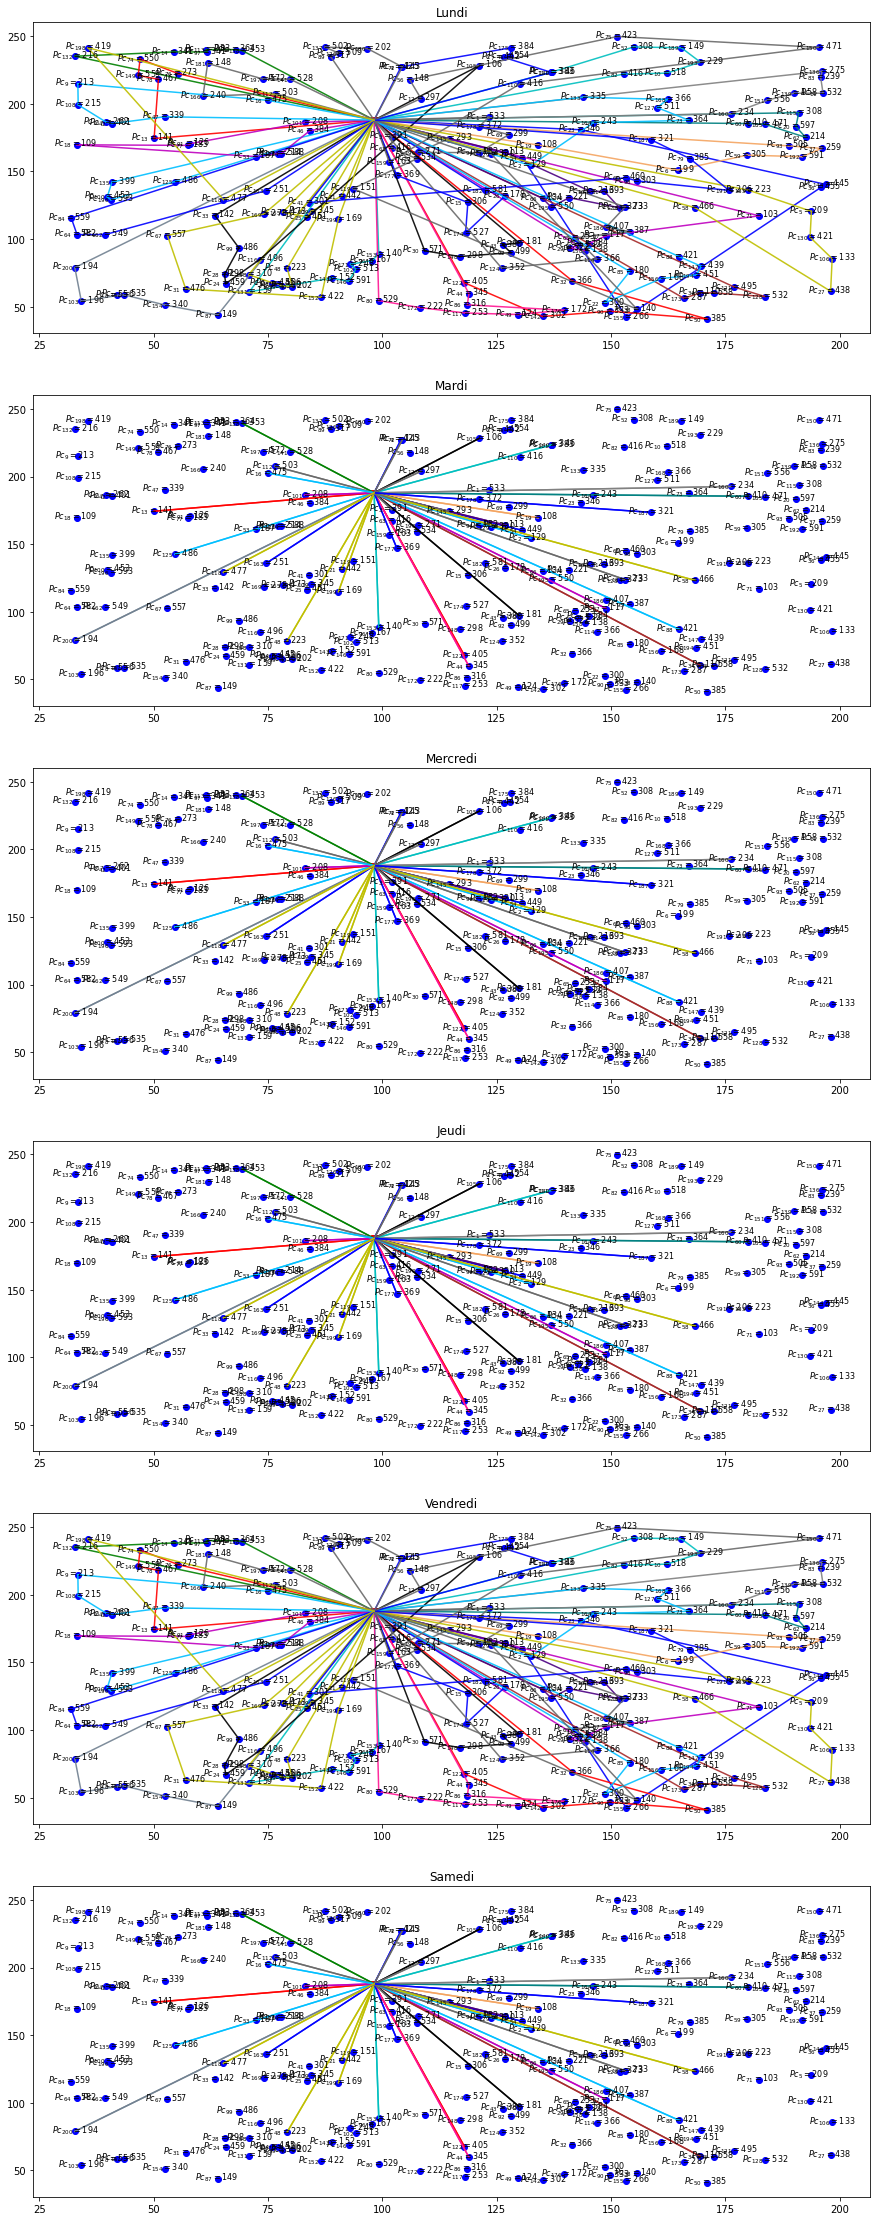

In [33]:
co=['g', 'b', 'y', 'r', 'c', 'm', 'black', 'teal', 'brown', 'sandybrown', 'slategrey','grey', 'indigo','deeppink',
'deepskyblue','dimgray','dimgrey','b', 'y', 'r', 'c', 'm', 'black','deepskyblue','b', 'y', 'deepskyblue',
'dimgray',
'dimgrey','b', 'y', 'deepskyblue',
'dimgray',
'dimgrey','b', 'y','g', 'b', 'y', 'r', 'c', 'm', 'black', 'teal', 'brown', 'sandybrown', 'slategrey','grey', 'indigo','deeppink',
'deepskyblue',
'dimgray',
'dimgrey','b', 'y', 'r', 'c', 'm', 'black','deepskyblue',
'dimgray','dimgrey','b', 'y', 'deepskyblue','dimgray','dimgrey','b', 'y', 'deepskyblue','dimgray','dimgrey','b', 'y']
%matplotlib inline
fig = plt.figure(figsize=(15,40))
day =['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi']
for i in range(1, 7):
    ax = fig.add_subplot(6, 1, i)
    ax.title.set_text(day[i-1])
    s = i
    ax.scatter(vrp['x'][1:],vrp['y'][1:],c='b')
    ax.plot(vrp['x'][0],vrp['y'][0],c='r',marker='s')
    for i in P:
        ax.annotate('$Pc_{%d}=%d$'%(i,P[i][2]),(P[i][0]-5,P[i][1]-1),c='black', size=8)
    for ind in range(next_cluster(grp)):
        av_arc=[i for i in xxx[ind] if i[3]==s]
        for i,j,k,d in av_arc:
            ax.plot([vrp['x'][i],vrp['x'][j]],[vrp['y'][i],vrp['y'][j]],c=co[ind],alpha=0.9)


## Analyse des résultats <a id="19"></a>

<h3> Evaluation du clustering </h3>

 <h4>Taux d'occupation </h4>
 Pour valider ces clusters formés, le taux d’exploitation est un indicateur crucial puisque chaque cluster est considéré comme un véhicule
 un taux élevé indique que nos ressourses(<b>vehicules</b>) sont bien utilisées 

In [34]:
evaluation = grouper(df)
evaluation['taux_occupation %'] = (round(evaluation['capacite']/Q *100,2))
evaluation = evaluation[['capacite','taux_occupation %']]
evaluation

capacite  taux_occupation %
clusters                             
0             1848              92.40
1             1961              98.05
10            1969              98.45
11            1993              99.65
12            2000             100.00
13            1960              98.00
14            1931              96.55
15            1990              99.50
16            1950              97.50
17            1961              98.05
18            1986              99.30
19            1990              99.50
2             1709              85.45
20            1966              98.30
21            1999              99.95
22            1987              99.35
23            1947              97.35
24            1906              95.30
25            1902              95.10
26            1958              97.90
27            1955              97.75
28            1918              95.90
29            1941              97.05
3             1791              89.55
30            1890              94.50
31            1905              95.25
32            1961              98.05
33            1998              99.90
34            1976              98.80
35             896              44.80
4             1970              98.50
5             1996              99.80
6             1929              96.45
7             2000             100.00
8             1982              99.10
9             1967              98.35

<h4>Mesure de dispersion </h4>

In [35]:
import plotly.express as px
fig = px.box(df, x="clusters", y="capacite", points="all")
fig.show()

On remarque que les capacités de stockage des patients pour chaque cluster sont <b>dispersées</b> ce qui explique qu'il y a pour <b>un même cluster</b> des patients de fréquences de visites <i>différentes</i>, ce qui influe sur le coût du transport.<br>
On peut prendre en considération cette remarque pour améliorer la solution proposée.

In [36]:
result

vehicule  Frequence_visite  Lundi  Mardi  Mercredi  Jeudi  \
patient 1          16                 2    1.0    0.0       0.0    0.0   
patient 2          23                 6    1.0    1.0       1.0    1.0   
patient 3          32                 6    1.0    1.0       1.0    1.0   
patient 4          27                 6    1.0    1.0       1.0    1.0   
patient 5          30                 2    1.0    0.0       0.0    0.0   
patient 6           9                 2    1.0    0.0       0.0    0.0   
patient 7          24                 2    1.0    0.0       0.0    0.0   
patient 8          10                 2    1.0    0.0       0.0    0.0   
patient 9          31                 2    1.0    0.0       0.0    0.0   
patient 10         20                 2    1.0    0.0       0.0    0.0   
patient 11         11                 2    1.0    0.0       0.0    0.0   
patient 12         28                 6    1.0    1.0       1.0    1.0   
patient 13         19                 6    1.0    1.0       1.0    1.0   
patient 14          0                 2    1.0    0.0       0.0    0.0   
patient 15         17                 2    1.0    0.0       0.0    0.0   
patient 16         31                 6    1.0    1.0       1.0    1.0   
patient 17         32                 2    1.0    0.0       0.0    0.0   
patient 18         21                 2    1.0    0.0       0.0    0.0   
patient 19          9                 6    1.0    1.0       1.0    1.0   
patient 20          7                 2    1.0    0.0       0.0    0.0   
patient 21          2                 6    1.0    1.0       1.0    1.0   
patient 22         26                 2    1.0    0.0       0.0    0.0   
patient 23          1                 2    1.0    0.0       0.0    0.0   
patient 24         22                 2    1.0    0.0       0.0    0.0   
patient 25          2                 2    1.0    0.0       0.0    0.0   
patient 26         17                 2    1.0    0.0       0.0    0.0   
patient 27         30                 2    1.0    0.0       0.0    0.0   
patient 28         22                 2    1.0    0.0       0.0    0.0   
patient 29          5                 2    1.0    0.0       0.0    0.0   
patient 30          6                 2    1.0    0.0       0.0    0.0   
...               ...               ...    ...    ...       ...    ...   
patient 171         4                 2    1.0    0.0       0.0    0.0   
patient 172        13                 2    1.0    0.0       0.0    0.0   
patient 173         8                 2    1.0    0.0       0.0    0.0   
patient 174        17                 2    1.0    0.0       0.0    0.0   
patient 175        24                 2    1.0    0.0       0.0    0.0   
patient 176        13                 2    1.0    0.0       0.0    0.0   
patient 177        17                 6    1.0    1.0       1.0    1.0   
patient 178        16                 2    1.0    0.0       0.0    0.0   
patient 179        18                 2    1.0    0.0       0.0    0.0   
patient 180        27                 2    1.0    0.0       0.0    0.0   
patient 181        15                 2    1.0    0.0       0.0    0.0   
patient 182        17                 2    1.0    0.0       0.0    0.0   
patient 183        30                 2    1.0    0.0       0.0    0.0   
patient 184        33                 6    1.0    1.0       1.0    1.0   
patient 185         7                 2    1.0    0.0       0.0    0.0   
patient 186        33                 2    1.0    0.0       0.0    0.0   
patient 187        34                 6    1.0    1.0       1.0    1.0   
patient 188        18                 2    1.0    0.0       0.0    0.0   
patient 189        20                 2    1.0    0.0       0.0    0.0   
patient 190        16                 2    1.0    0.0       0.0    0.0   
patient 191        34                 2    1.0    0.0       0.0    0.0   
patient 192         9                 2    1.0    0.0       0.0    0.0   
patient 193      

<h3>Merci</h3>


<h3>By: Houssem Zidani & Haithem Ben Drissi</h3>